In [5]:
import pandas as pd
import numpy as np
import os
import torch 
import torch.nn.functional as F


In [6]:
cuda = True if torch.cuda.is_available() else False

In [7]:
def prepare_trte_data(data_folder, view_list):
    num_view = len(view_list)
    labels_tr = np.loadtxt(os.path.join(data_folder, "labels_tr.csv"), delimiter=',')
    labels_te = np.loadtxt(os.path.join(data_folder, "labels_te.csv"), delimiter=',')
    labels_tr = labels_tr.astype(int)
    labels_te = labels_te.astype(int)
    data_tr_list = []
    data_te_list = []
    for i in view_list:
        data_tr_list.append(np.loadtxt(os.path.join(data_folder, str(i)+"_tr.csv"), delimiter=','))
        data_te_list.append(np.loadtxt(os.path.join(data_folder, str(i)+"_te.csv"), delimiter=','))
    num_tr = data_tr_list[0].shape[0]
    num_te = data_te_list[0].shape[0]
    data_mat_list = []
    for i in range(num_view):
        data_mat_list.append(np.concatenate((data_tr_list[i], data_te_list[i]), axis=0))
    data_tensor_list = []
    for i in range(len(data_mat_list)):
        data_tensor_list.append(torch.FloatTensor(data_mat_list[i]))
        if cuda:
            data_tensor_list[i] = data_tensor_list[i].cuda()
    idx_dict = {}
    idx_dict["tr"] = list(range(num_tr))
    idx_dict["te"] = list(range(num_tr, (num_tr+num_te)))
    data_train_list = []
    data_all_list = []
    for i in range(len(data_tensor_list)):
        data_train_list.append(data_tensor_list[i][idx_dict["tr"]].clone())
        data_all_list.append(torch.cat((data_tensor_list[i][idx_dict["tr"]].clone(),
                                       data_tensor_list[i][idx_dict["te"]].clone()),0))
    labels = np.concatenate((labels_tr, labels_te))
    
    return data_train_list, data_all_list, idx_dict, labels

In [8]:
data_folder = "data/ROSMAP"
view_list = [i for i in range(1,4)]
print(data_folder, view_list)

data/ROSMAP [1, 2, 3]


In [9]:
data_train_list, data_all_list, idx_dict, labels = prepare_trte_data(data_folder, view_list)

In [10]:
data_train_list[0].shape, data_all_list[0].shape, labels.shape

(torch.Size([245, 200]), torch.Size([351, 200]), (351,))

In [11]:
data_train_list[0]

tensor([[0.1814, 0.1253, 0.0948,  ..., 0.4051, 0.3220, 0.2137],
        [0.1328, 0.0995, 0.1496,  ..., 0.3944, 0.3312, 0.2165],
        [0.1112, 0.0700, 0.1279,  ..., 0.3985, 0.3038, 0.1417],
        ...,
        [0.1704, 0.0867, 0.1646,  ..., 0.3373, 0.3310, 0.1844],
        [0.0932, 0.1133, 0.2190,  ..., 0.3823, 0.2815, 0.2076],
        [0.1266, 0.1656, 0.1084,  ..., 0.4291, 0.3139, 0.1836]])

In [4]:
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

In [18]:
od = np.random.rand(10,15)
od.shape

(10, 15)

In [19]:
cs = cosine_similarity(od)
cs.shape

(10, 10)

In [20]:
threshold = 0.7
bin_adj_mat = np.where(cs>threshold, 1, 0)
G = nx.from_numpy_array(bin_adj_mat)

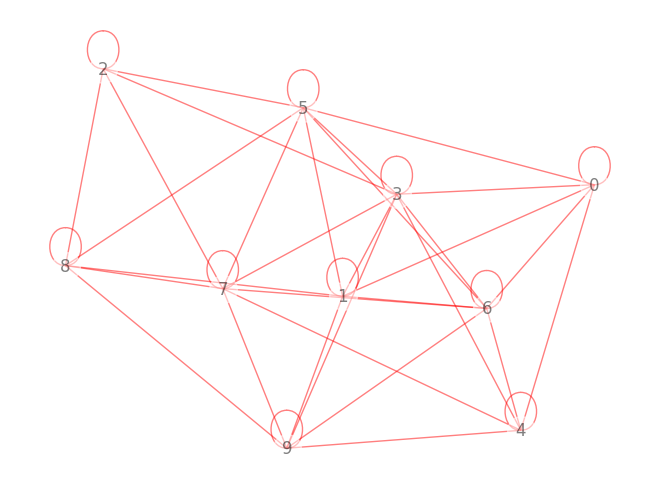

In [40]:
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='white', edge_color='red', node_size=400, alpha=0.5)
plt.show()

In [30]:
def cosine_distance_torch(x1, x2=None, eps=1e-8):
    x2 = x1 if x2 is None else x2
    w1 = x1.norm(p=2, dim=1, keepdim=True)
    w2 = w1 if x2 is x1 else x2.norm(p=2, dim=1, keepdim=True)
    return 1 - torch.mm(x1, x2.t()) / (w1 * w2.t()).clamp(min=eps)

In [33]:
od = torch.tensor(od,dtype=torch.float32)
test = cosine_distance_torch(od)
test.shape

/tmp/ipykernel_30904/4261194971.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  od = torch.tensor(od,dtype=torch.float32)


torch.Size([10, 10])

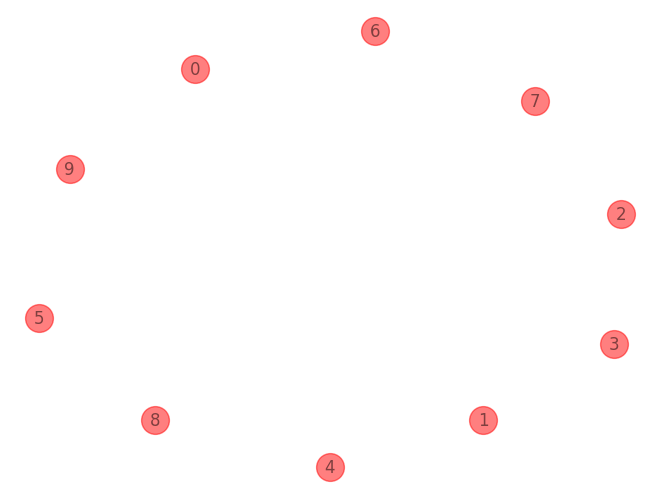

In [39]:
threshold = 0.7
ts = np.where(test>threshold, 1, 0)
Gt =nx.from_numpy_array(ts)
pos = nx.spring_layout(Gt)
nx.draw(Gt, pos, with_labels=True, node_color='red', edge_color='red', node_size=400, alpha=0.5)
plt.show()